<a href="https://colab.research.google.com/github/Sarathy-Hub/Bio/blob/main/Original_Skim_Lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SkimLit** Model 📄

**What are we doing?**
> We are building an NLP model using Deep Learning that will make PubMed abstracts easier to read, comprehend and interpret

* The paper that we are replicating first is **PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts** at https://arxiv.org/abs/1710.06071

* The architecture that is used in the above paper comes from another paper titled  **Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts** at https://arxiv.org/pdf/1612.05251.pdf

## Get the Data

Since we will be replicating the paper that is mentioned above initially, we need to get access to the dataset that have used for their paper. That dataset is publicly avaialble on the GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

So, let's take the data from the GitHub into the Colab Notebook

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 29.25 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


**Note**

* `PubMed_200k_RCT` is the total raw dataset
* `PubMed_200k_RCT_numbers_replaced_with_at_sign` is the preprocessed version of the above dataset where the numbers are replaced with the @ sign
* `PubMed_20k_RCT` is the subset of the initial full dataset
* `PubMed_20k_RCT_numbers_replaced_with_at_sign` is the preprocessed version of the above dataset

In [ ]:
# Let us start by exploring the subset preprocessed dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# We are going to start our experimental modelling with the PubMed_20K model where numbers are replaced with @ sign
# Create the data directory
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Get all the filenames present in the data directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Pre-process the data

After we have got the data from the GitHub, the next step is to become one with the data, which means we have to **VISUALISE** the data in all ways that we can

One way to visualize the data that is given in the files of the `train.txt` is to read all the lines that is present in the file

In [ ]:
# Create a function that will read all the lines present in a text file and retrun them in the form of a list

def read_lines (filename):
  '''
  Takes a filename as an input and reads all the lines that are present in the file and returns them in the form a list

  Args
    filename (str): Name of the text file

  Returns:
    A list containing all the lines of the file
  '''

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Read all the lines in the file train.txt

train_lines = read_lines (data_dir + "train.txt")

# Look at the first 20 lines of the file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

**Note**

In the file, before every abstract there is a number preceeded by a '#' and after every after abstract, there is a newline `\n` character.

So, our aim is to convert this into a form that can be fed into a model

In [ ]:
len(train_lines)

210040

**What do I want my data to actually llook like**

The `.readlines()` function that ran above returns the data in a very raw form.

However, I would want the data to be a list of dictionaries for each line / each element in the list that gets returned by the `read_lines()` function

```
[
  {
    'line_number': 0,
    'target': 'OBJECTIVE',
    'text': "To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n",
    'total_lines': 11
  }
]
```

In the above dictionary, the `total_lines` property is the total number of lines in an abstract

### How to exactly pre-process this data?

* For each abstract, it starts with a ###, so check if the line starts with the ### if it does, then that is your abstract ID, this will help you keep track of the number of lines in the abstract

* Each abstract ends with the `\n` or the whitespace, so check for the whitespace and if the condition satisfies, it means we are the end of an abstract.
> So record each line in that abstract and sperate the `target` from the main `text`

In [ ]:
# Create the preprocessing function that does the work of sampling data into our required form

def preprocess_abstract_lines (filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """

  # Get all the lines from the filename
  input_lines = read_lines(filename)

  # Create an empty abstract
  abstract_lines = ""

  # Create the list which will store the dictionaries
  abstract_samples = []

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):
      # check to see if the line starts with ###
      abs_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}

        target_text_split = abstract_line.split('\t')
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines_in_abstract"] = len(abstract_line_split) - 1
        abstract_samples.append (line_data)
    else:
      abstract_lines += line


  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_abstract_lines(data_dir + "train.txt")
val_samples = preprocess_abstract_lines(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_abstract_lines(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 751 ms, sys: 164 ms, total: 915 ms
Wall time: 940 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines_in_abstract': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines_in_abstract': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines_in_abstract': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines_in_abstract': 11},
 {'target': 'METHODS',
  'text': 'second

## Explortory Data Analysis

In [ ]:
# Turn the dictionaries created in the above piece of code into DataFrames so that they can be easily interpreted

import pandas as pd

train_df = pd.DataFrame (train_samples)
val_df = pd.DataFrame (val_samples)
test_df = pd.DataFrame (test_samples)

In [ ]:
train_df.head(10)

,target,text,line_number,total_lines_in_abstract
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Check how well is the data distributed under each label

train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

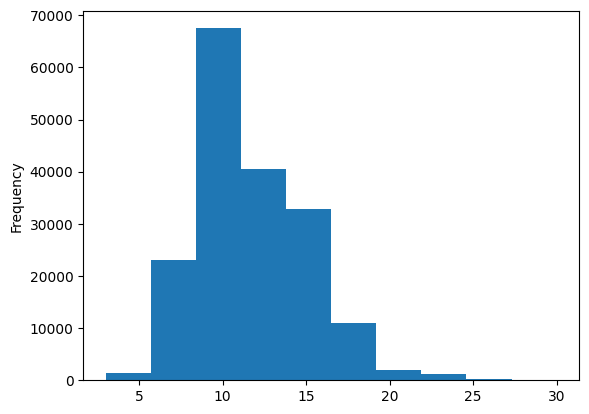

In [ ]:
# Get the distribution of the length of sentences

train_df["total_lines_in_abstract"].plot.hist();

**Note**: The most common number of lines in each abstract is **10**

### Get the list of sentences

* Convert the **texts** present in the dataframe to **sentences / list of sentences**

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
len(train_sentences), len (val_sentences), len (test_sentences)

(180040, 30212, 30135)

### Turn the Labels into Numbers ( for the ML models )

* To turn the label data into numbers, we will use the `OneHotEncoder` and the `LabelEncoder`

* Although just doing the `LabelEncoding` would be enough, the mulitclass classification loss function `CategoricalCrossEntropy` prefers data to be One Hot Encoded

In [ ]:
# One Hot Encode the labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder (sparse_output = False) # if you set sparse = True, it is incompatible with Tensorflow

train_labels_one_hot = one_hot_encoder.fit_transform (train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform (val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform (test_df["target"].to_numpy().reshape(-1, 1))

# OneHotEncoder requires a 2D array to be passed, so it needs to be reshaped by adding an axes to make it 2D

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encode the labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder =  LabelEncoder()

train_labels_encoded = label_encoder.fit_transform (train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform (val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform (test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get the class names and the number of classes

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

### Model 0: Base Line Model with TF-IDF

* Our baseline model is going to be the **TF-IDF** model with **Multinomial Naive Bayes Classifier**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the pipeline
model_0_baseline = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline into the data
model_0_baseline.fit(X = train_sentences,
                     y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the model's accuracy using the score() method

model_0_baseline.score(X = val_sentences,
                       y = val_labels_encoded)

0.7218323844829869

The model returns an accuracy of 72.2% approximately.

It would be great if the performance of the model is NOT ONLY judged by the accuracy but by other parameters like

* F1 Score
* Recall
* Precision

In [ ]:
# Get the helper functions module
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-20 04:40:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-20 04:40:38 (60.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import the calculate results function

from helper_functions import calculate_results

In [ ]:
# Make predictions

baseline_preds = model_0_baseline.predict (val_sentences)
baseline_preds[:10]

# This is the predictions that will be compared with the labels to evaluate the model

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
# Use the calculate_results function to evaluate the model is a more detailed way

baseline_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the data for future modelling Experiments

* in order to prepare the data for future modelling experiments, we need to turn the data (text) into numeric format too i.e Vectorize and Embed it

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Find the average length of each sentence in the training data

sent_lengths = [len(sen.split()) for sen in train_sentences] # length of every sentence in the training data
avg_length = np.mean (sent_lengths)
tf.round(avg_length)

<tf.Tensor: shape=(), dtype=float64, numpy=26.0>

* We have computed the average length of a sentence to be 26

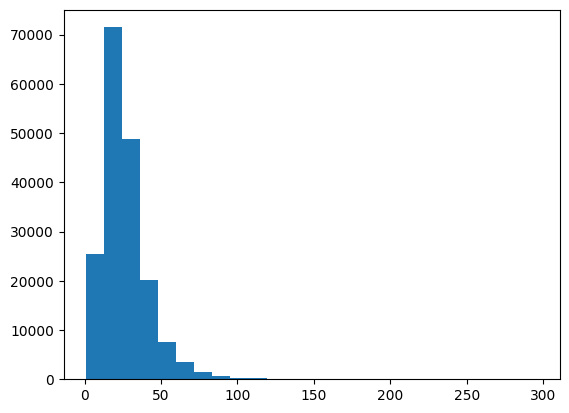

In [ ]:
# Check the distribution and the percentile of the sentence length

import matplotlib.pyplot as plt
plt.hist (sent_lengths, bins = 25);

* Majority of the sentences dont exceed the length of 55 ish

* Its safe to estimate that 95% of the sentences fall around the length of 60.

* This information is very important when we go to vectorize the sentence to decide what the maximum length / tokens can be

In [ ]:
# How many words in 95% of the sentences
output_seq_len = int(np.percentile(sent_lengths, 95))
output_seq_len

55

In [ ]:
# What is the maximum sentence length in the training dataset
max(sent_lengths)

296

### Create Text Vectorizer

In [ ]:
# Get the total number of words in the PubMed20K (from the paper)
max_tokens = 68000 # this is taken from the research paper we are trying to replicate

# Since 95% of the sentences fall under the length of 55, that could be set as the output sequence length in the vectorization layer

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization (max_tokens = max_tokens, # maximum number of words in the vocabulary
                                  output_sequence_length = output_seq_len) # set to 55 which is what is the length of majority sentences

In [ ]:
# Fit the text vectorization layer to the data

text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out the vectroization layer on a random sentence from the training data

import random

random_sentence = random.choice (train_sentences)

print(f"Original Sentence: {random_sentence}\n")
print(f"Length of the random selected sentence: {len(random_sentence.split())}\n")

print(f"Text Vectorized form {random_sentence}:\n {text_vectorizer([random_sentence])}")

Original Sentence: dental health was recorded and expressed as d@mft/d@mft , and as time of caries onset .

Length of the random selected sentence: 16

Text Vectorized form dental health was recorded and expressed as d@mft/d@mft , and as time of caries onset .:
 [[ 1823    97    10   382     3  2281    25 39552     3    25    63     4
   2580   779     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# Get all the words from the vocabulary and analyse it

pubmed_20k_dataset = text_vectorizer.get_vocabulary()
print (f"Total length of the PubMed 20K Dataset: {len(pubmed_20k_dataset)}")
print (f"Top 5 most common words from the dataset: {pubmed_20k_dataset[:5]}")
print (f"Least common 5 words from the dataset: {pubmed_20k_dataset[-5:]}")

Total length of the PubMed 20K Dataset: 64841
Top 5 most common words from the dataset: ['', '[UNK]', 'the', 'and', 'of']
Least common 5 words from the dataset: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the configuration of the text vectorizer layer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create the custom embedding layer

* In the text vectorization layer, the text data will be turned into positive integers.

* In the `Embedding` layer, the positive integers are turned to **feature vectors** which give a **relationship between the words** and is a richer far better embedding

In [ ]:
# Create the token embedding layer

token_embed = layers.Embedding (input_dim = len(pubmed_20k_dataset),
                            output_dim = 128, # popular choice
                            mask_zero = True, # used to handle variable sequence length (saves computation space)
                            embeddings_initializer = "uniform",
                            name = "Token_Embedding")

In [ ]:
# Demonstrating the embedding that is taking place

target_sentence = random.choice (train_sentences)

print (f"Original Sentence: {target_sentence}")
print (f"Length: {len(target_sentence.split())}\n")

# Perform the Text Vectorization
vectorized_text = text_vectorizer ([target_sentence])
print (f"Vectorized form: \n {vectorized_text}\n")

# Perform the token embedding
embed_sentence = token_embed (vectorized_text)
print (f"Embedded form: \n {embed_sentence}\n")

print (f"Shape of Vectorized Text: {vectorized_text.shape}\n Shape of Embedded form of the text {embed_sentence.shape}")

Original Sentence: significant improvements were seen in the ability of the third-year students who received verbal and written feedback to prioritize the information presented in the case and in their total score on the problem-solving rubric .
Length: 35

Vectorized form: 
 [[   37   408     9   683     5     2   805     4     2 11817   515    67
     80  1825     3  2057   877     6 19817     2   380  1248     5     2
    825     3     5   120    76   101    18     2  4938 17975     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded form: 
 [[[-0.02924297  0.00033865 -0.02584806 ...  0.00147667 -0.02981593
   -0.02986169]
  [ 0.04759245  0.02720293  0.0227705  ... -0.00134404  0.02027855
    0.01959756]
  [-0.00786579 -0.00930853  0.02368363 ...  0.00929196  0.037726
    0.04249046]
  ...
  [ 0.03256363  0.03196427 -0.03576943 ...  0.02901551  0.01709953
    0.02277574]
  [ 0.03256363  0.03196427 

### Create Datasets

* Use the `tf.data` API to enable faster data loading
* Turn our data into `Prefetch` batches of dataset


In [ ]:
# Turn data into tensorflow batches of dataset

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
# Turn the dataset created above to prefetch data in order to load data faster and in a more efficient manner

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: Conv1D

After numerically encoding the text and the label in our training data, now we can build deep models where these preprocessed texts can be passed through to get outputs

* Build the model
* Compile the model
* Fit the model
* Evaluate the model
* Make predictions with the model

```
Inputs -> Tokenize -> Embedding -> Layers (Conv1D) -> Output (Predicted Probability)
```

In [ ]:
tf.random.set_seed (42)

inputs = layers.Input (shape = (1,), dtype = "string")
vectorized_data = text_vectorizer (inputs)
token_embedding = token_embed (vectorized_data)

x = layers.Conv1D (filters = 64,
                   kernel_size = 5,
                   padding = "same",
                   activation = "relu") (token_embedding)

x = layers.GlobalAveragePooling1D ()(x)
outputs = layers.Dense (num_classes, activation = "softmax", name = "Output_Layer_Conv1D") (x)

model_1 = tf.keras.Model (inputs, outputs)

In [ ]:
# Compile the model

model_1.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

In [ ]:
# Get the summary

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 Token_Embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Fit and train the model on the data

history_model_1 = model_1.fit (train_dataset,
                               epochs = 3,
                               steps_per_epoch = int (0.1 * len(train_dataset)), # look at only 10% of the batches of the training data
                               validation_data = val_dataset,
                               validation_steps = int (0.1 * len(val_dataset))) # look at only 10% of the batches for the validation data

# By looking at onyl 10% of the training and validation batches, we want to increase the computation speed

Epoch 1/3
562/562 [==============================] - 67s 118ms/step - loss: 0.9207 - accuracy: 0.6320 - val_loss: 0.6945 - val_accuracy: 0.7320
Epoch 2/3
562/562 [==============================] - 68s 122ms/step - loss: 0.6667 - accuracy: 0.7499 - val_loss: 0.6372 - val_accuracy: 0.7656
Epoch 3/3
562/562 [==============================] - 64s 115ms/step - loss: 0.6287 - accuracy: 0.7687 - val_loss: 0.6062 - val_accuracy: 0.7836


In [ ]:
# Evaluate the model
model_1.evaluate (val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.6099 - accuracy: 0.7811


[0.6099303960800171, 0.7810803651809692]

In [ ]:
# Make predictions with the model

conv_pred_probs = model_1.predict(val_dataset)
conv_pred_probs, conv_pred_probs.shape

945/945 [==============================] - 6s 6ms/step


(array([[3.9428520e-01, 2.2028384e-01, 7.9288282e-02, 2.7775449e-01,
         2.8388148e-02],
        [4.9312496e-01, 2.3801887e-01, 8.6391754e-03, 2.5557572e-01,
         4.6412335e-03],
        [1.5470250e-01, 9.5810592e-03, 1.7273140e-03, 8.3395201e-01,
         3.7048660e-05],
        ...,
        [1.6744596e-06, 9.3885517e-04, 5.9704273e-04, 1.2642028e-06,
         9.9846113e-01],
        [5.8240820e-02, 4.1316292e-01, 1.0685384e-01, 6.9056496e-02,
         3.5268596e-01],
        [2.1746767e-01, 5.5671322e-01, 5.1279265e-02, 7.0310995e-02,
         1.0422887e-01]], dtype=float32),
 (30212, 5))

* Each element has 5 columns representing the 5 classes out of which the predictions are made

* Each class has a probability associated with it. The maximum out of the 5 predicted probability is the class that it is pointing towards

In [ ]:
# Turn the probabilites to classes
conv_preds = tf.argmax (conv_pred_probs, axis = 1)
conv_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Evaluate the performance of the model

model_1_results = calculate_results (y_true = val_labels_encoded,
                   y_pred = conv_preds)

### Model 2: Feature Extraction from pre-trained **TOKEN EMBEDDING**

* **Model Structure**

```
Inputs -> Uinversal Sequence Encoder (Vectorize and Embed) -> Layers -> Outputs (Probability)
```

In [ ]:
# Download the pretrained Tensorflow Hub USE

import tensorflow_hub as hub

pre_trained_feature_extractor_layer = hub.KerasLayer ("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                      trainable = False,
                                                      name = "Pre_Trained_Embedding_Layer")

In [ ]:
# Test the pre trained embedding layer on a random sentence

random_target_sentence = random.choice (train_sentences)
print(f"Random target sentence: {random_target_sentence}\n")

token_embedded_sentence = pre_trained_feature_extractor_layer([random_target_sentence])
print (f"Sentence After Token Embedding: \n{token_embedded_sentence[0][:50]} ...")

print (token_embedded_sentence.shape)

Random target sentence: primary outcome measures were the amount of postoperative ( @h ) blood loss and incidence of pph during the postoperative period .

Sentence After Token Embedding: 
[ 1.7079392e-02  4.1751370e-02 -1.9290885e-02 -4.2194244e-02
  3.8277186e-02 -6.8896845e-02  3.1818017e-02 -1.0433250e-02
  1.4354401e-02  4.8254665e-02  9.1870308e-02 -5.2611060e-03
 -1.2070449e-02 -2.5603859e-02  4.0543918e-02 -2.2128660e-02
 -7.2364561e-02  5.3036413e-03 -5.2223388e-02 -2.0665504e-02
 -5.4946121e-02  8.9896195e-02  2.2639966e-02 -7.8320354e-03
 -1.5403914e-02 -2.2876732e-02  2.8381513e-02  8.4051797e-03
  5.1548786e-02  5.5367085e-03  6.4834692e-02  7.7226900e-02
  4.0245891e-02  5.9323803e-02 -6.0322136e-02 -6.2081005e-02
  7.0851217e-03  3.2560958e-03 -4.7737569e-02 -3.0639607e-02
  8.5496642e-05  5.0783765e-02  5.5654716e-02  3.4555290e-03
 -1.0431904e-02  4.9368050e-02 -1.1859961e-02 -2.5381336e-02
 -7.1501158e-02  4.7763262e-02] ...
(1, 512)


* There is no need for the **Text Vectorization** layer here because the USE takes care of that

In [ ]:
tf.random.set_seed (42)

inputs = layers.Input (shape = [], dtype = "string")
token_embed_text = pre_trained_feature_extractor_layer (inputs)

x = layers.Dense (128, activation = "relu")(token_embed_text)
outputs = layers.Dense (num_classes, activation = "softmax")(x)

model_2 = tf.keras.Model (inputs, outputs, name = "Pre_Trained_Embedding_Model")

In [ ]:
# Compile the model

model_2.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

In [ ]:
# Model summary

model_2.summary()

Model: "Pre_Trained_Embedding_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Pre_Trained_Embedding_Laye  (None, 512)               256797824 
 r (KerasLayer)                                                  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit and train the model

history_model_2 = model_2.fit (train_dataset,
                               epochs = 3,
                               steps_per_epoch = int (0.1 * len (train_dataset)),
                               validation_data = val_dataset,
                               validation_steps = int (0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9153 - accuracy: 0.6522 - val_loss: 0.7961 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7674 - accuracy: 0.7018 - val_loss: 0.7539 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7507 - accuracy: 0.7115 - val_loss: 0.7371 - val_accuracy: 0.7141


In [ ]:
# Evaluate the model

model_2.evaluate (val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7399 - accuracy: 0.7145


[0.7399304509162903, 0.7144511938095093]

In [ ]:
# Make predictions with the model

pre_trained_pred_probs = model_2.predict (val_dataset)
pre_trained_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.4108634 , 0.3993523 , 0.00232215, 0.17896648, 0.00849567],
       [0.3579593 , 0.47683126, 0.00267338, 0.15933879, 0.00319725],
       [0.2430825 , 0.14400549, 0.02017889, 0.55783993, 0.03489317],
       ...,
       [0.00194784, 0.00756778, 0.05825323, 0.00097685, 0.93125427],
       [0.00482048, 0.05152644, 0.1989284 , 0.00181424, 0.74291044],
       [0.20243418, 0.2753694 , 0.4429557 , 0.00939008, 0.06985061]],
      dtype=float32)

In [ ]:
pre_trained_preds = tf.argmax (pre_trained_pred_probs, axis = 1)
pre_trained_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results (y_true = val_labels_encoded,
                   y_pred = pre_trained_preds)

### Model 3: Character Embedding Layer

* Model 3 is a **character embedding** **Conv1D** model where the embedding takes place on a character by character level

* This model involves creating a **character level tokenizer** where each character in the sentence is embedded

* Create a character level embedding by **first tokenizing the characters** in a sentence and them **passing those tokenized characters into an embedding**

In [ ]:
# Make a function to split the sentences into individual characters

def split_chars (sentence):
  return " ".join (list(sentence))

In [ ]:
# Test the above function

random_sentence = random.choice (train_sentences)
split_chars (random_sentence)

't h e   d a t a   a n d   s a f e t y   m o n i t o r i n g   b o a r d   r e c o m m e n d e d   e a r l y   t e r m i n a t i o n   o f   t h e   t r i a l   d u e   t o   s u p e r i o r i t y   o f   a b l a t i o n   f o r   t h e   p r i m a r y   o u t c o m e   a n d   t h e   p o t e n t i a l   f o r   p a t i e n t   s a f e t y   i s s u e s   i f   t h e   t r i a l   c o n t i n u e d   .'

In [ ]:
# Split the sequnece level data into character level data

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[1]

'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'

In [ ]:
# Figure out what is the average character length

char_lens = [len(sentence) for sentence in train_sentences]
avg_char_lens = np.mean(char_lens)
avg_char_lens

149.3662574983337

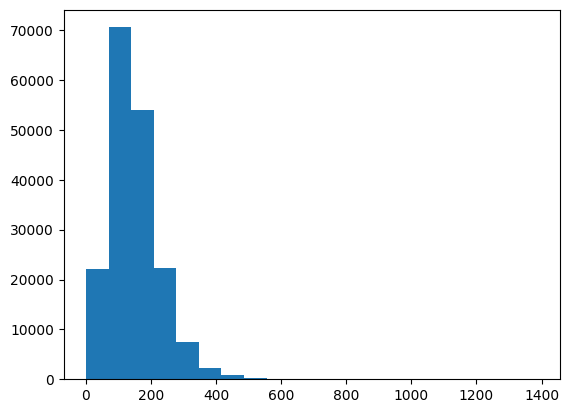

In [ ]:
# Check out the distribution of characters across the sentences

plt.hist (char_lens, bins = 20);

In [ ]:
# How many characters are in 95% of the sentences

output_seq_char_len = int(np.percentile (char_lens, 95))
output_seq_char_len

290

* **95%** of the sentences have **290 characters** in them

In [ ]:
# Get all the characters for the character level embedding

import string

character_tokens = string.ascii_lowercase + string.digits + string.punctuation
character_tokens

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create a character level tokenizer

MAX_TOKEN_LENGTH = len(character_tokens) + 2 # Include the space and 'OOV'

char_vectorizer = TextVectorization (max_tokens = MAX_TOKEN_LENGTH,
                                     output_sequence_length = output_seq_char_len,
                                     standardize = "lower_and_strip_punctuation",
                                     name = "Tokenize_Character")

# Fit the Token Vectorizer layer to the training data
char_vectorizer.adapt (train_chars)

In [ ]:
# Study the features of the Character Vectorizer

char_vec_vocab = char_vectorizer.get_vocabulary()
print (f"Total number of characters in the Vocabulary: {len(char_vec_vocab)}")
print (f"5 Most common characters: {char_vec_vocab[:5]}")
print (f"5 Least common characters: {char_vec_vocab[-5:]}")

Total number of characters in the Vocabulary: 28
5 Most common characters: ['', '[UNK]', 'e', 't', 'i']
5 Least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test the vectorization layer on a random sentence

random_target_sentence = random.choice (train_chars)
print (f"Target Sentence \n {random_target_sentence}")

print (f"Number of characters in target sentence: \n {len(random_target_sentence.split())}\n")

vectorized_output = char_vectorizer([random_target_sentence])

print (f"Vectorized Output of target sentence: \n{vectorized_output}\n")
print (f"Length of Vectorized Output: {len(vectorized_output[0])}")

Target Sentence 
 t h e   r e s u l t s   s h o w e d   t h a t   t h e   s e l f - m a n u a l   t h e r a p y   p r o g r a m   s i g n i f i c a n t l y   d e c r e a s e d   p a i n   a t   @   w e e k s   ,   i n c r e a s e d   f l e x i o n   a n d   e x t e n s i o n   a t   @   a n d   @   w e e k s   ,   a n d   i m p r o v e d   t h e   k o o s   i n   p a i n   i t e m   a n d   s f - @   i n   p h y s i c a l   f u n c t i o n   a n d   m e n t a l   h e a l t h   i t e m s   .
Number of characters in target sentence: 
 198

Vectorized Output of target sentence: 
[[ 3 13  2  8  2  9 16 12  3  9  9 13  7 20  2 10  3 13  5  3  3 13  2  9
   2 12 17 15  5  6 16  5 12  3 13  2  8  5 14 19 14  8  7 18  8  5 15  9
   4 18  6  4 17  4 11  5  6  3 12 19 10  2 11  8  2  5  9  2 10 14  5  4
   6  5  3 20  2  2 23  9  4  6 11  8  2  5  9  2 10 17 12  2 24  4  7  6
   5  6 10  2 24  3  2  6  9  4  7  6  5  3  5  6 10 20  2  2 23  9  5  6
  10  4 15 14  8  7 21  2 10  3 13  2 23  7  7 

### Create Embedding Layer for the character level embedding

In [ ]:
char_embedding = layers.Embedding (input_dim = MAX_TOKEN_LENGTH,
                                   output_dim = 25, # taken from the paper being replicated
                                   mask_zero = False, # is set to True this messes up model_5
                                   name = "Character_Embedding")

In [ ]:
# Test the two created layers on the random sentence from training data

target_sentence = random.choice (train_chars)

print(f"Target Sentence: \n{target_sentence}\n")
print(f"Number of characters in the target sentence: {len(target_sentence.split())}\n")

char_vectorized = char_vectorizer ([target_sentence])
print (f"Vectorizing the characters: \n {char_vectorized}\n")
print (f"Number of characters in vectorized output: \n {len(char_vectorized[0])}\n")

char_embed = char_embedding (char_vectorized)
print (f"Embedding the characters: \n {char_embed}\n")
print (f"Shape of the embedded characters: \n {char_embed.shape}")

Target Sentence: 
t h e   a d d i t i o n   o f   c b t   t o   u s u a l   c a r e   i s   c o s t - e f f e c t i v e   i n   p a t i e n t s   w h o   h a v e   n o t   r e s p o n d e d   t o   a n t i d e p r e s s a n t s   .

Number of characters in the target sentence: 90

Vectorizing the characters: 
 [[ 3 13  2  5 10 10  4  3  4  7  6  7 17 11 22  3  3  7 16  9 16  5 12 11
   5  8  2  4  9 11  7  9  3  2 17 17  2 11  3  4 21  2  4  6 14  5  3  4
   2  6  3  9 20 13  7 13  5 21  2  6  7  3  8  2  9 14  7  6 10  2 10  3
   7  5  6  3  4 10  2 14  8  2  9  9  5  6  3  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0

* Each character is embedded into a 25 length feature vector

### Buidling a Conv1D model to fit the character embeddings

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input (shape = (1,), dtype = tf.string)
char_tokenize = char_vectorizer (inputs)
char_embed = char_embedding (char_tokenize)

x = layers.Conv1D (filters = 64,
                  kernel_size = 5,
                  padding = "same",
                  activation = "relu")(char_embed)

x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

model_3 = tf.keras.Model (inputs, outputs)

In [ ]:
# Compile the model

model_3.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

In [ ]:
# Get the model_3 summary

model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 Tokenize_Character (TextVe  (None, 290)               0         
 ctorization)                                                    
                                                                 
 Character_Embedding (Embed  (None, 290, 25)           1750      
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                           

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit and train the model

history_model_3 = model_3.fit (train_char_dataset,
                               epochs = 3,
                               steps_per_epoch = int(0.1 * len(train_char_dataset)),
                               validation_data = val_char_dataset,
                               validation_steps = int (0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 20ms/step - loss: 1.2764 - accuracy: 0.4786 - val_loss: 1.0579 - val_accuracy: 0.5821
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 1.0117 - accuracy: 0.5923 - val_loss: 0.9572 - val_accuracy: 0.6157
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.9298 - accuracy: 0.6352 - val_loss: 0.8803 - val_accuracy: 0.6546


In [ ]:
# Evaluate the model

model_3.evaluate (val_char_dataset)

945/945 [==============================] - 6s 7ms/step - loss: 0.8945 - accuracy: 0.6503


[0.8944864869117737, 0.6503044962882996]

In [ ]:
# Make predictions using the model

model_3_pred_probs = model_3.predict (val_char_dataset)
model_3_pred_probs[:10]

945/945 [==============================] - 7s 7ms/step


array([[2.00619951e-01, 3.95521253e-01, 8.78316090e-02, 2.08595470e-01,
        1.07431687e-01],
       [1.83373913e-01, 5.07854164e-01, 1.55457240e-02, 2.79386312e-01,
        1.38398921e-02],
       [1.78650126e-01, 3.03215623e-01, 1.47514969e-01, 2.72188634e-01,
        9.84306410e-02],
       [9.02866386e-03, 1.94661170e-02, 8.50162804e-01, 6.30882382e-03,
        1.15033485e-01],
       [1.96187906e-02, 5.10298572e-02, 6.97029352e-01, 2.15049945e-02,
        2.10816965e-01],
       [4.09481261e-04, 7.47583923e-04, 8.43470991e-01, 3.62556864e-04,
        1.55009285e-01],
       [2.83773267e-03, 1.04420986e-02, 8.11745346e-01, 2.70368834e-03,
        1.72271177e-01],
       [1.39854461e-01, 1.89777404e-01, 1.39779598e-01, 1.42680481e-01,
        3.87908012e-01],
       [3.63200437e-03, 1.06230881e-02, 1.26634777e-01, 6.92240475e-03,
        8.52187693e-01],
       [1.20232187e-01, 2.98646480e-01, 1.57824174e-01, 2.01255113e-01,
        2.22042069e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.argmax (model_3_pred_probs, axis = 1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 1, 2, 2, 2, 2, 4, 4, 1])>

In [ ]:
# Assess the performance of the model

model_3_results = calculate_results (y_true = val_labels_encoded,
                   y_pred = model_3_preds)

### Model 4: Token Embeddings + Character Encoding

* In **model 4**, we will be **combining** the **token embeddings** and **character encodings** to create the model

* Create a **Token Embedding Layer** similar to Model 1
* Create a **Character Encoding Layer** similar to Model 3
* **Combine 1 and 2** using the `layers.Concatenate`
* Build a series of output layers on top of point 3

In [ ]:
# 1. Set up the token model
token_inputs = layers.Input (shape = [], dtype = tf.string, name = "Token_Input")
token_embed = pre_trained_feature_extractor_layer (token_inputs) # Using the TF Hub Token Embedding Layer
token_output = layers.Dense (128, activation = "relu")(token_embed)
token_embed_model = tf.keras.Model(inputs = token_inputs,
                                   outputs = token_output)

# 2. Set up the character embedding model
char_embed_inputs = layers.Input (shape = (1,), dtype = tf.string, name = "Char_Embedding_Input")
char_vectors = char_vectorizer (char_embed_inputs)
char_embeds = char_embedding (char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeds)
char_embed_model = tf.keras.Model (inputs = char_embed_inputs,
                                   outputs = char_bi_lstm)

# 3.Concatenate the above models as a single layer
token_char_combined = layers.Concatenate (name = "Token_Character_Hybrid")([token_embed_model.output,
                                                                         char_embed_model.output])

# 4. Create additional layers
combined_dropout = layers.Dropout (0.5)(token_char_combined)
combined_dense = layers.Dense (200, activation = "relu") (combined_dropout)
final_dropout = layers.Dropout (0.5) (combined_dense)
output_layer = layers.Dense (num_classes, activation = "softmax", name = "Hybrid_Output") (final_dropout)

# 5. Construct the first hybrid model
token_char_hybrid_model = tf.keras.Model (inputs = [token_embed_model.input,
                                                    char_embed_model.input],
                                          outputs = output_layer,
                                          name = "Hybrid_Model")

In [ ]:
token_char_hybrid_model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_Embedding_Input (Inpu  [(None, 1)]                  0         []                            
 tLayer)                                                                                          
                                                                                                  
 Token_Input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 Tokenize_Character (TextVe  (None, 290)                  0         ['Char_Embedding_Input[0][0]']
 ctorization)                                                                                     
                                                                                       

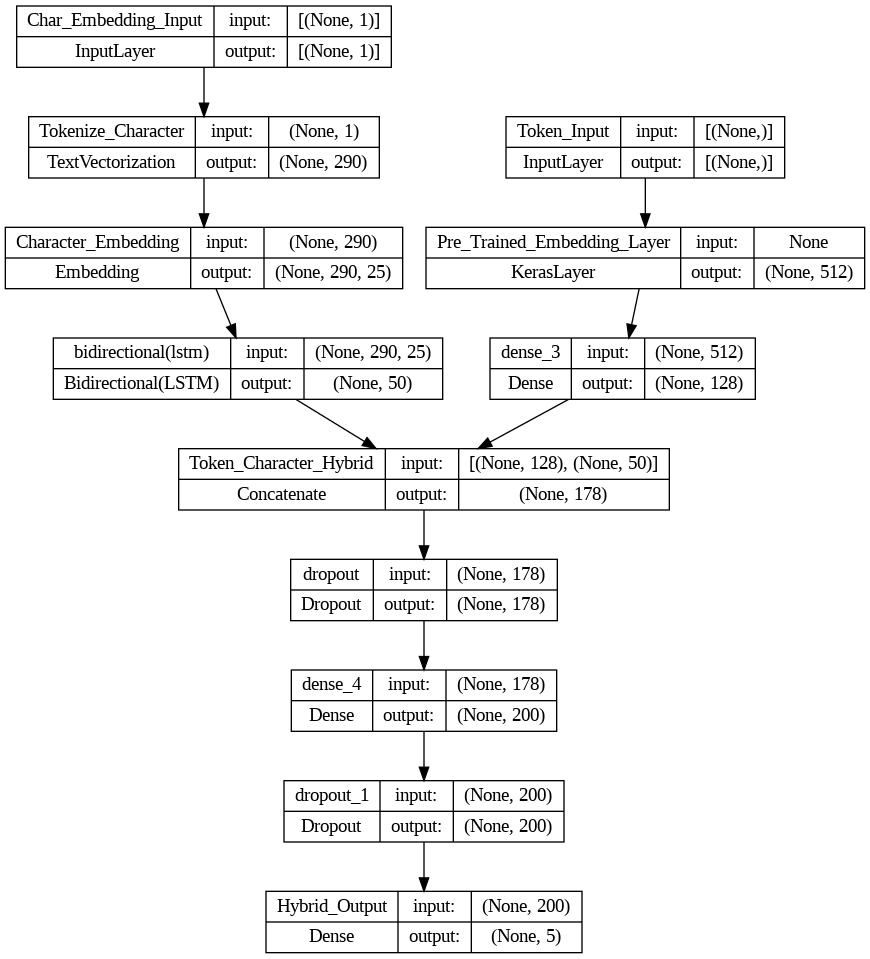

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model (token_char_hybrid_model, show_shapes = True)

In [ ]:
# Compile the model

token_char_hybrid_model.compile (loss = "categorical_crossentropy",
                                 optimizer = tf.keras.optimizers.Adam(),
                                 metrics = ["accuracy"])

#### Creating Datasets fot the Hybrid Model

In [ ]:
# Combine the characters and token into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices ((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices (train_labels_one_hot)

# Combine data and labels to make a dataset
train_dataset_hybrid = tf.data.Dataset.zip ((train_char_token_data, train_char_token_labels))

# Create the batches and prefect the data
train_dataset_hybrid = train_dataset_hybrid.batch(32).prefetch(tf.data.AUTOTUNE)

# Same steps as above for the validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices ((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices (val_labels_one_hot)

# Combine the data and labels into a dataset
val_dataset_hybrid = tf.data.Dataset.zip ((val_char_token_data, val_char_token_labels))

# Create the batches and prefetch the data
val_dataset_hybrid = val_dataset_hybrid.batch(32).prefetch (tf.data.AUTOTUNE)

In [ ]:
train_dataset_hybrid

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_dataset_hybrid

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit and train the model

history_model_hybrid = token_char_hybrid_model.fit (train_dataset_hybrid,
                                                    epochs = 5,
                                                    steps_per_epoch = int(0.1 * len (train_dataset_hybrid)),
                                                    validation_data = val_dataset_hybrid,
                                                    validation_steps = int(0.1 * len (val_dataset_hybrid)))

Epoch 1/5
562/562 [==============================] - 126s 213ms/step - loss: 0.9672 - accuracy: 0.6153 - val_loss: 0.7795 - val_accuracy: 0.7018
Epoch 2/5
562/562 [==============================] - 110s 195ms/step - loss: 0.7899 - accuracy: 0.6951 - val_loss: 0.7110 - val_accuracy: 0.7334
Epoch 3/5
562/562 [==============================] - 108s 193ms/step - loss: 0.7615 - accuracy: 0.7106 - val_loss: 0.6856 - val_accuracy: 0.7400
Epoch 4/5
562/562 [==============================] - 105s 187ms/step - loss: 0.7365 - accuracy: 0.7215 - val_loss: 0.6642 - val_accuracy: 0.7500
Epoch 5/5
562/562 [==============================] - 107s 191ms/step - loss: 0.7357 - accuracy: 0.7201 - val_loss: 0.6515 - val_accuracy: 0.7513


In [ ]:
# Evaluate the model
token_char_hybrid_model.evaluate (val_dataset_hybrid)

945/945 [==============================] - 45s 47ms/step - loss: 0.6597 - accuracy: 0.7489


[0.6597002744674683, 0.7489408254623413]

In [ ]:
# Make predictions using the hybrid model
hybrid_model_pred_probs = token_char_hybrid_model.predict (val_dataset_hybrid)
hybrid_model_pred_probs

945/945 [==============================] - 52s 54ms/step


array([[5.6044453e-01, 2.1977833e-01, 4.3689855e-03, 2.0956346e-01,
        5.8447071e-03],
       [4.1112366e-01, 4.6753547e-01, 6.7629772e-03, 1.1001955e-01,
        4.5583472e-03],
       [2.9452559e-01, 6.3082129e-02, 1.4344306e-01, 4.5400730e-01,
        4.4941857e-02],
       ...,
       [2.4272762e-04, 6.8313716e-04, 5.7725627e-02, 8.7576664e-05,
        9.4126093e-01],
       [4.1643353e-03, 1.5087993e-02, 3.7348315e-01, 1.5918280e-03,
        6.0567272e-01],
       [2.9214245e-01, 3.5473689e-01, 2.8077742e-01, 8.1534600e-03,
        6.4189814e-02]], dtype=float32)

In [ ]:
hybrid_model_probs = tf.argmax (hybrid_model_pred_probs, axis = 1)
hybrid_model_probs

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results (y_true = val_labels_encoded,
                   y_pred = hybrid_model_probs)

### Model 5: Token Embeddings + Character Embeddings + Positional Embeddings

* **Feature Engineering**: Add some features that are not straighaway available into your model for it to train and understand the data better

* The features that you engineering **should be available at test time**

* **Features** to be engineered: `line_number`, `total_lines`

#### Create positional embeddings

In [ ]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

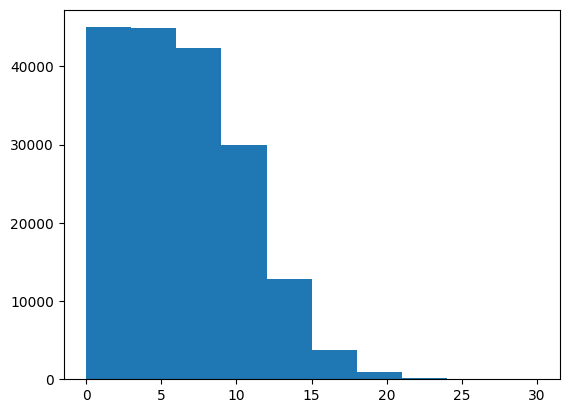

In [ ]:
# Plot the distribution of line numbers
plt.hist(train_df["line_number"]);

* A laaaarge amount of data have the number of lines to be less than 20, so if we are one-hot encoding the `line_number` data, then it is suitable to have a depth of around 17-10 to avoid a lot of sentences to have additional zeros in them

In [ ]:
train_line_number_one_hot = tf.one_hot (train_df["line_number"].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot (val_df["line_number"].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot (test_df["line_number"].to_numpy(), depth = 15)

train_line_number_one_hot.shape, val_line_number_one_hot.shape, test_line_number_one_hot.shape

(TensorShape([180040, 15]), TensorShape([30212, 15]), TensorShape([30135, 15]))

* **REPEAT THE SAME STEPS AS ABOVE TO VISUALISE AND ONE HOT ENCODE THE `total_lines` FEATURE**

In [ ]:
train_df["total_lines_in_abstract"].value_counts()

total_lines_in_abstract
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

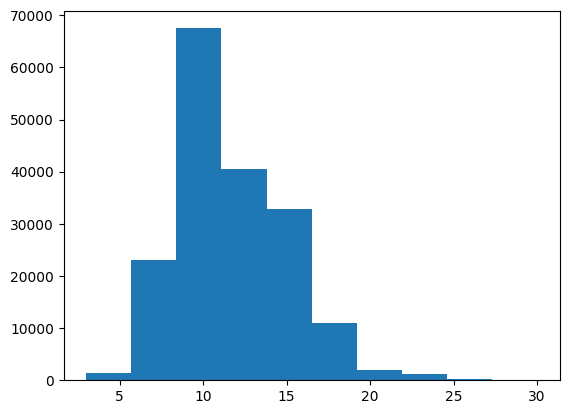

In [ ]:
# Plot out its distribution

plt.hist (train_df["total_lines_in_abstract"]);

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines_in_abstract"].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines_in_abstract"].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot (test_df["total_lines_in_abstract"].to_numpy(), depth = 20)

train_total_lines_one_hot.shape, val_total_lines_one_hot.shape, test_total_lines_one_hot.shape

(TensorShape([180040, 20]), TensorShape([30212, 20]), TensorShape([30135, 20]))

#### Steps to create the first ever **TRIBID Model**

* Create the token level model
* Create the character level model
* Create the model for `line_number`
* Create the model for `total_lines` feature
* Combine the outputs of 1, 2 using `tf.layers.Concatenate`
* Combine the outputs of 3, 4, 5 using `tf.layers.Concatenate`
* Create an output layer to accept the **TRIBID** model input and give out the predicted probabilities

In [ ]:
# 1. Create the token-level model
token_inputs = layers.Input (shape = [], dtype = tf.string, name = "Token_Embedding_Input")
token_embedding = pre_trained_feature_extractor_layer (token_inputs)
token_outputs = layers.Dense (128, activation = "relu")(token_embedding)
token_embedding_model = tf.keras.Model (inputs = token_inputs,
                                        outputs = token_outputs)

# 2. Create the Character Level Embedding layer
char_inputs = layers.Input (shape = (1,), dtype = tf.string, name = "Character_Embedding_Input")
char_vectors = char_vectorizer (char_inputs)
char_embed = char_embedding (char_vectors)
char_bi_LSTM = layers.Bidirectional(layers.LSTM(25))(char_embed)
char_embedding_model = tf.keras.Model (inputs = char_inputs,
                                       outputs = char_bi_LSTM)

# 3. Create the model for the line_number feature
line_number_inputs = layers.Input (shape = (15,), dtype = tf.int32, name = "Line_Number_Inputs")
x = layers.Dense (32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model (inputs = line_number_inputs,
                                    outputs = x)

# 4. Create the model for total_lines feature
total_lines_inputs = layers.Input (shape = (20,), dtype = tf.int32, name = "Total_Lines_Inputs")
y = layers.Dense (32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model (inputs = total_lines_inputs,
                                    outputs = y)

# 5. Combine the outputs of 1 & 2
combined_embeddings = layers.Concatenate (name = "Combined_Embeddings")([token_embedding_model.output,
                                                                         char_embedding_model.output])

z = layers.Dense (256, activation = "relu") (combined_embeddings)
z = layers.Dropout (0.5)(z)

# 6. Combine 3, 4, 5
combined_tribid_layer = layers.Concatenate (name = "Tribid_Layer")([line_number_model.output,
                                                                    total_lines_model.output,
                                                                    z])

output_layer = layers.Dense(num_classes, activation = "softmax")(combined_tribid_layer)

tribid_model = tf.keras.Model (inputs = [token_embedding_model.input,
                                         char_embedding_model.input,
                                         line_number_model.input,
                                         total_lines_model.input],
                               outputs = output_layer)

In [ ]:
tribid_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Character_Embedding_Input   [(None, 1)]                  0         []                            
 (InputLayer)                                                                                     
                                                                                                  
 Token_Embedding_Input (Inp  [(None,)]                    0         []                            
 utLayer)                                                                                         
                                                                                                  
 Tokenize_Character (TextVe  (None, 290)                  0         ['Character_Embedding_Input[0]
 ctorization)                                                       [0]']                   

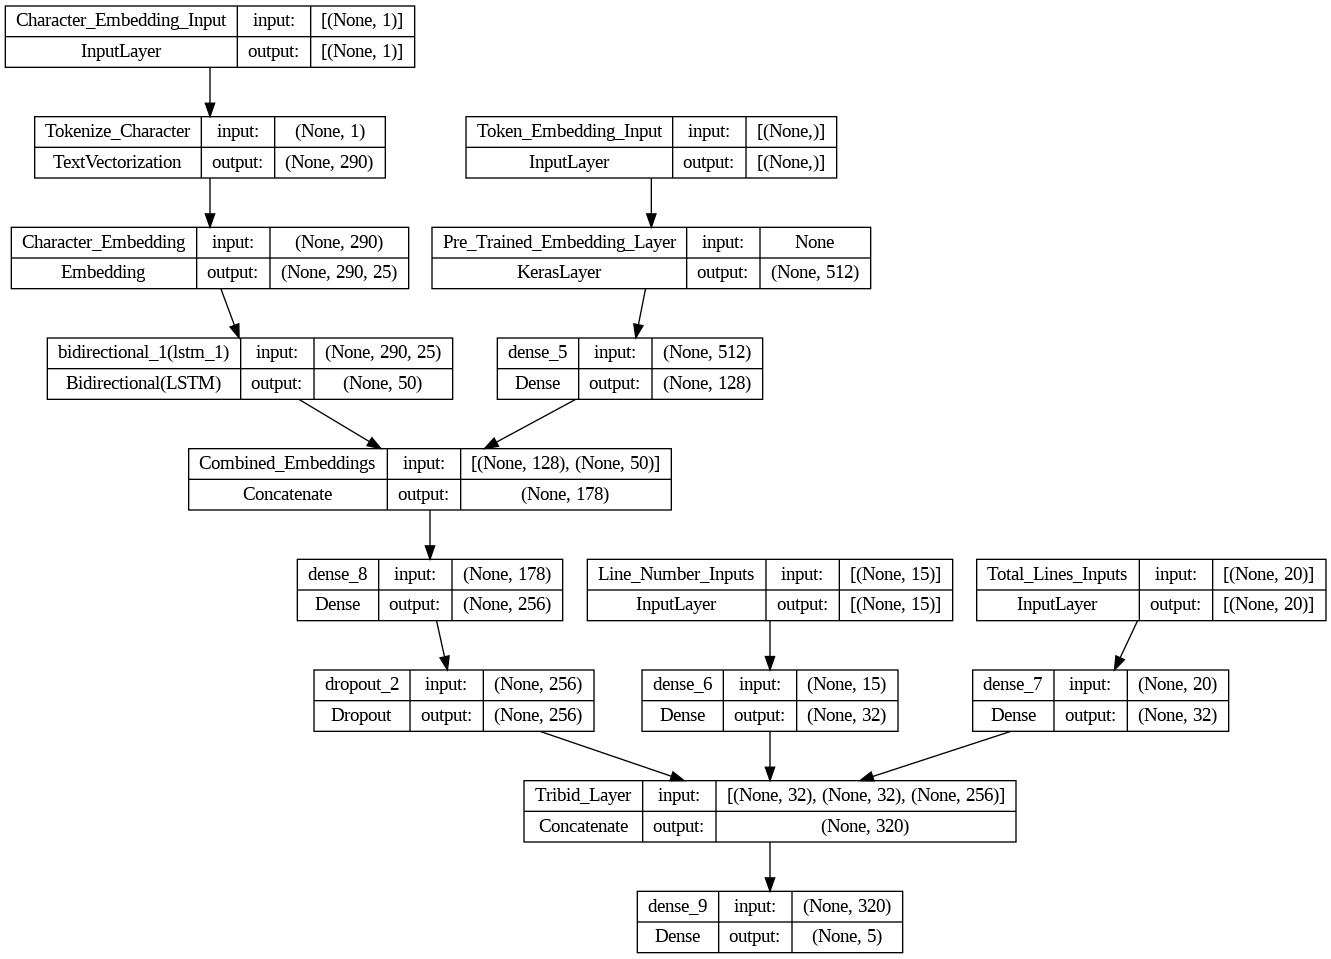

In [ ]:
# Plot and visualise the flow of the model

from tensorflow.keras.utils import plot_model

plot_model(tribid_model, show_shapes = True)

In [ ]:
# Compile the model

tribid_model.compile (loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.2),
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

In [ ]:
# Creating test and validation datasets

train_tribid_data = tf.data.Dataset.from_tensor_slices ((train_sentences,
                                                         train_chars,
                                                         train_line_number_one_hot,
                                                         train_total_lines_one_hot))
train_tribid_labels = tf.data.Dataset.from_tensor_slices (train_labels_one_hot)
train_tribid_dataset = tf.data.Dataset.zip((train_tribid_data, train_tribid_labels))
train_tribid_dataset = train_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribid_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                      val_chars,
                                                      val_line_number_one_hot,
                                                      val_total_lines_one_hot))
val_tribid_labels = tf.data.Dataset.from_tensor_slices (val_labels_one_hot)
val_tribid_dataset = tf.data.Dataset.zip ((val_tribid_data, val_tribid_labels))
val_tribid_dataset = val_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit and train the data

history_tribid_model = tribid_model.fit (train_tribid_dataset,
                                         epochs = 3,
                                         steps_per_epoch = int(0.1 * len(train_tribid_dataset)),
                                         validation_data = val_tribid_dataset,
                                         validation_steps = int(0.1 * len(val_tribid_dataset)))

Epoch 1/3
562/562 [==============================] - 116s 194ms/step - loss: 0.1556 - accuracy: 0.7315 - val_loss: 0.1353 - val_accuracy: 0.8112
Epoch 2/3
562/562 [==============================] - 106s 188ms/step - loss: 0.1338 - accuracy: 0.8166 - val_loss: 0.1307 - val_accuracy: 0.8311
Epoch 3/3
501/562 [=========================>....] - ETA: 11s - loss: 0.1314 - accuracy: 0.8248

In [ ]:
# Evaluate the model

tribid_model.evaluate (val_tribid_dataset)

945/945 [==============================] - 65s 69ms/step - loss: 0.1293 - accuracy: 0.8335


[0.12925884127616882, 0.8335429430007935]

In [ ]:
# Make prediction based on your model

tribid_model_pred_probs = tribid_model.predict(val_tribid_dataset)
tribid_model_preds = tribid_model_pred_probs.argmax(axis = 1)
tribid_model_preds

945/945 [==============================] - 46s 49ms/step


array([0, 0, 3, ..., 4, 4, 1])

In [ ]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = tribid_model_preds)

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.108037,0.777243,0.781080,0.778478
pretrained_token_embed,71.445121,0.714839,0.714451,0.711307
custom_char_embed_conv1d,65.030451,0.647090,0.650305,0.639626
hybrid_char_token_embed,74.894082,0.746255,0.748941,0.743595
tribrid_pos_char_token_embed,83.354296,0.833272,0.833543,0.833069


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

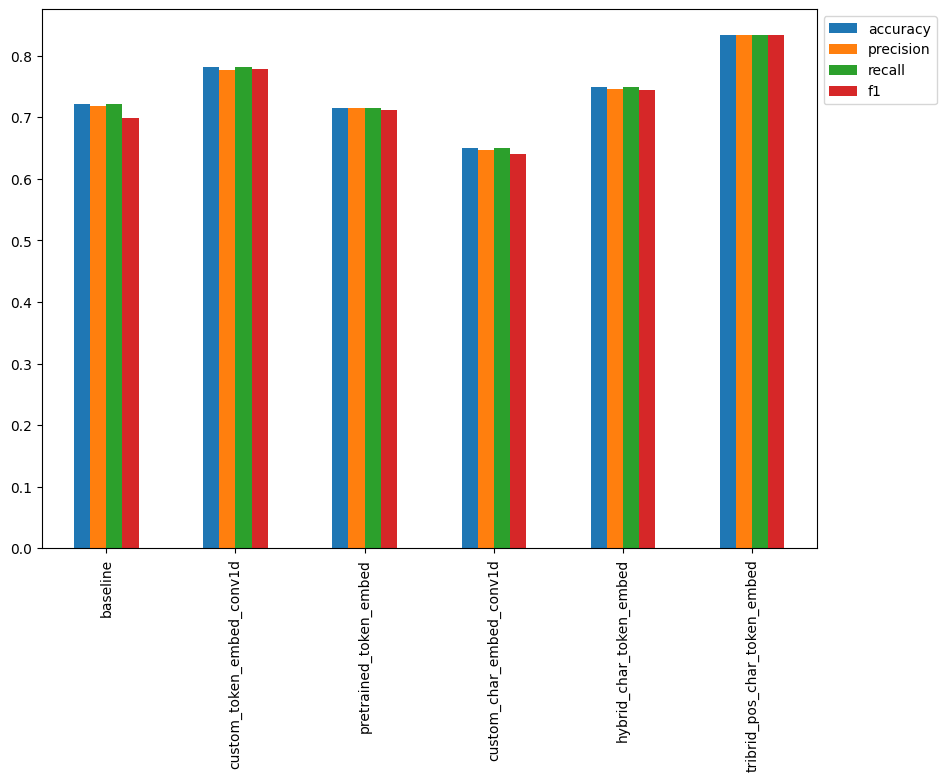

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

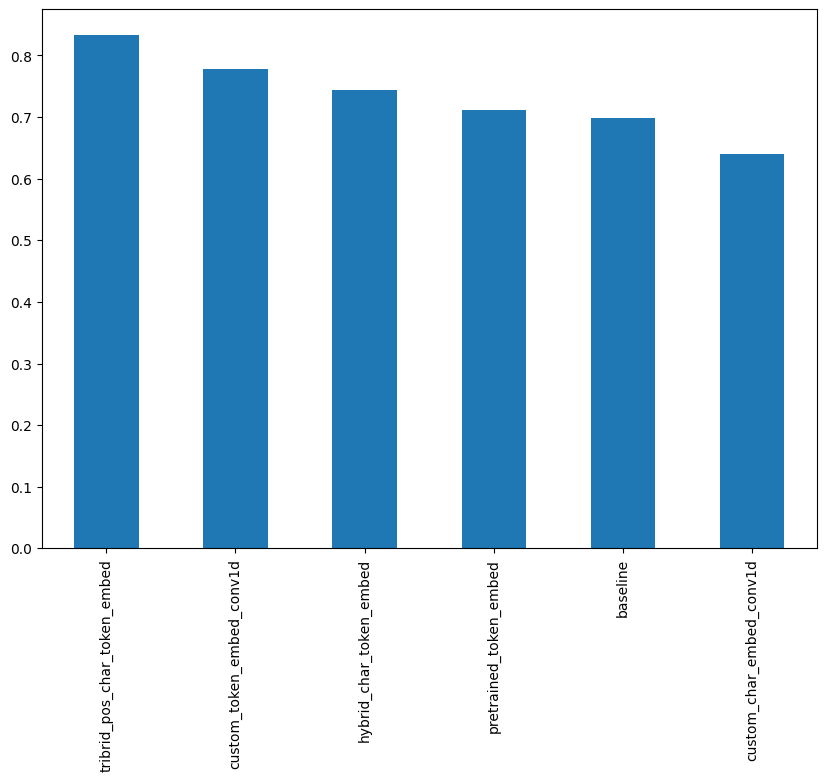

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
tribid_model.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [ ]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-04-20 05:37:56--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  78.7MB/s    in 18s     

2024-04-20 05:38:15 (51.5 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/

In [ ]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         tribid_model_preds)
loaded_model_results

{'accuracy': 83.35429630610354,
 'precision': 0.8332716269300485,
 'recall': 0.8335429630610354,
 'f1': 0.8330688417301417}

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-04-20 06:36:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-04-20 06:36:13 (63.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 2.18 s, sys: 20.5 ms, total: 2.2 s
Wall time: 2.48 s


array([[0.26448247, 0.11054239, 0.01762425, 0.5750656 , 0.03228522],
       [0.06927065, 0.03808299, 0.7078093 , 0.09543166, 0.08940545],
       [0.13772693, 0.04937518, 0.54679686, 0.16341296, 0.10268812],
       [0.09659058, 0.17111641, 0.5257438 , 0.07601642, 0.1305327 ],
       [0.04459695, 0.08888112, 0.45675462, 0.04623033, 0.36353692],
       [0.03265214, 0.14626433, 0.517485  , 0.04088319, 0.2627153 ],
       [0.03290153, 0.1779621 , 0.07166826, 0.02870873, 0.68875927],
       [0.01843721, 0.13495173, 0.32084185, 0.03389724, 0.49187198]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
